In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pylab as plt

from nfft import nfft, ndft
from numpy.fft import fft2, fftshift
import scipy.fftpack

In [2]:
IMG_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.img'
HEADER_PATH = '../data/scanVisit__0003__0003/MRI__0001/t2/Native/Original__0001/NIFTI/f0001.hdr'

img = nib.load(IMG_PATH)
data = img.get_data()

## Plot transposed matrix

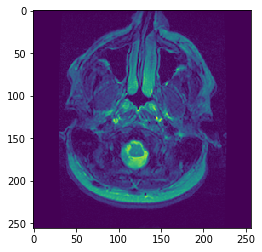

In [3]:
plt.imshow(data.T[0])

## 2d Fourier Transform

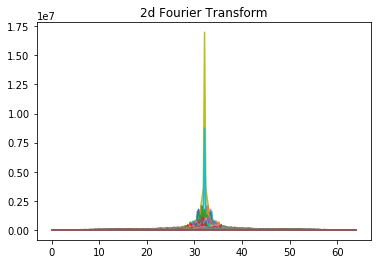

In [4]:
img = data.T[0]

def plot_2dtransform(img):
    yf = fft2(img)
    fshift = fftshift(yf)
#     yf = fshift.flatten()
    yf = fshift

    # Number of samplepoints: 512
    N = yf.shape[0]
    # sample spacing
    T = 1.0 / N * 2 

    xf = np.linspace(0.0, 1.0/(2.0 * T), yf.shape[0])
#     print(N, T, flattened.shape, xf)

    plt.plot(xf, np.abs(yf))
    plt.title("2d Fourier Transform")
    plt.show()
    
plot_2dtransform(img)

## Fourier Transform with numpy

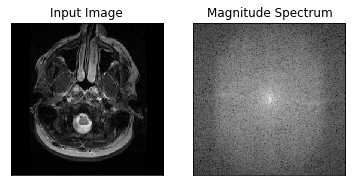

In [5]:
img = data.T[0]

def get_fourier_transform(img, skip_fshift=False):
    fourier_transf = fft2(img)
    if not skip_fshift:
        fourier_transf = fftshift(fourier_transf)
    magnitude_spectrum = np.log(np.abs(fourier_transf))
    return magnitude_spectrum

transformed_img = get_fourier_transform(img)

plt.subplot(121), plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(transformed_img, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

## Flatten array to 1d

In [6]:
flattened = transformed_img.flatten()
transformed_img.shape, flattened.shape

((256, 256), (65536,))

## Non-equispaced Fast Fourier Transform (NFFT)

In [7]:
x = np.arange(len(flattened))
f_k = flattened

print("Input shapes", x.shape, f_k.shape)

# non-equispaced fast Fourier transform
nfft_res = nfft(x, f_k)
nfft_res.shape, nfft_res

Input shapes (65536,) (65536,)


((65536,),
 array([586965.25713101+3.40928894e-10j, 586965.25713139+6.81925366e-10j,
        586965.25713064-1.36402235e-09j, ...,
        586965.22426246-9.95421000e-14j, 586965.22426246-9.95421000e-14j,
        586965.22426246-9.95421000e-14j]))

## NFFT plot

shape (256, 256)


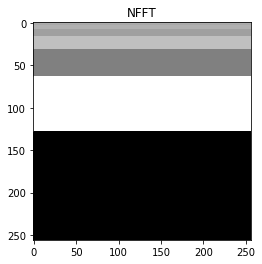

In [8]:
reshaped = nfft_res.reshape(transformed_img.shape)
# res_transform = np.fft.fft2(reshaped)
# res_transform_shift = np.fft.fftshift(reshaped)
print("shape {}".format(reshaped.shape))
res = transformed_img = 20 * np.log(np.abs(reshaped))
plt.title('NFFT')
plt.imshow(res, cmap = 'gray')

In [9]:
len(res), len(set(res.flatten()))

(256, 21)

In [10]:
print("Matrix after NFFT operation:\n\n \
    # of elements: {}\n \
    # of distinct elements: {}".format(len(res), len(set(res.flatten()))))

Matrix after NFFT operation:

     # of elements: 256
     # of distinct elements: 21
